# Imports

In [263]:
import numpy as np
import pandas as pd
import json
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import uncertainties.unumpy as unp
import uncertainties as unc

# Functions

In [264]:
def exponential(x, a, b):
    return a * np.exp(b * x)

def weighted_exp_fit(y, cut=8, weights='linear'):
    days = len(y)
    x = np.arange(days)[y > 0]
    y = y[y > 0]
    weights = np.ones(cut) #uniform weights
    if weights == 'linear':
        weights = np.arange(1, cut+1)
    if cut < len(y):
        x = x[len(y)-cut:]
        y = y[len(y)-cut:]
    else:
        weights = weights[len(weights)-len(y):]
    sigma = np.sqrt(y) / weights #linear weights become quadratic as in the least squares method a sigma^2 appears
    if len(y) < 2:
        return [0, 0], [[0, 0], [0, 0]]
    popt, pcov = curve_fit(exponential, x, y, sigma=sigma)
    return popt, pcov

# Data

In [265]:
df_regions = pd.read_json('../pcm-dpc-COVID-19/dati-json/dpc-covid19-ita-regioni.json')
df_pop = pd.read_csv('dati_regioni.csv')

# Local exponential fit — Italian regions

In [266]:
#creating a new minimalist dataframe
df_temp = df_regions[df_regions.data == max(df_regions.data.values)]
df_temp = df_temp[df_temp.denominazione_regione != '']
df_forecast = df_temp[['data', 'codice_regione', 'denominazione_regione']].copy()
df_forecast['casi_domani'] = 0
df_forecast['std_casi_domani'] = 0
df_forecast['morti_domani'] = 0
df_forecast['std_morti_domani'] = 0
df_forecast['casi_dopodomani'] = 0
df_forecast['std_casi_dopodomani'] = 0
df_forecast['morti_dopodomani'] = 0
df_forecast['std_morti_dopodomani'] = 0

In [267]:
df_forecast.head(1)

,data,codice_regione,denominazione_regione,casi_domani,std_casi_domani,morti_domani,std_morti_domani,casi_dopodomani,std_casi_dopodomani,morti_dopodomani,std_morti_dopodomani
567,2020-03-22 17:00:00,13,Abruzzo,0,0,0,0,0,0,0,0


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':


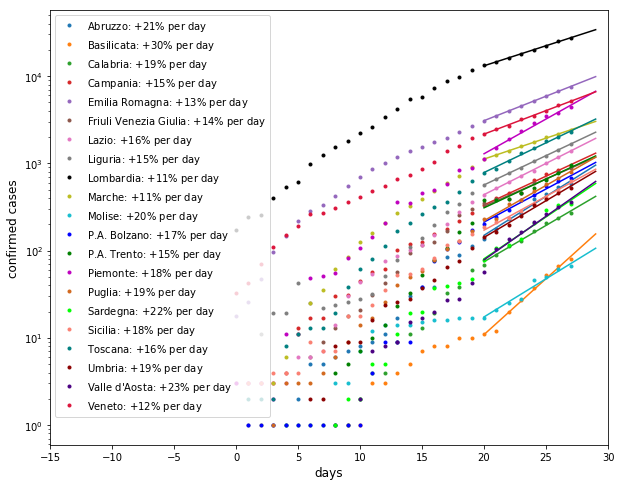

In [268]:
fig, ax = plt.subplots(figsize=(10,8))

denominazioni = np.unique(df_regions.denominazione_regione.values)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
          'tab:brown', 'tab:pink', 'tab:gray', 'black', 'tab:olive',
          'tab:cyan', 'b', 'g', 'm', 'chocolate',
          'lime', 'salmon', 'teal', 'darkred', 'indigo',
          'crimson'] #21 colori per VENTI regioni (mannaggia al Trentino - Alto Adige)

labels = ['casi', 'morti']
for i, den in enumerate(denominazioni):
    dfr = df_regions[df_regions.denominazione_regione == den]
    for j, y in enumerate((dfr.totale_casi.values, dfr.deceduti.values)):
        days = len(y)
        x = np.arange(days)
        popt, pcov = weighted_exp_fit(y, cut=8, weights='linear')
        a, b = unc.correlated_values(popt, pcov)
        slope = unc.nominal_value(b)
        std = unc.std_dev(b)
        xx = np.concatenate((x, [x[-1] + 1, x[-1] + 2])) #extrapolation till the day after tomorrow
        yy = a * unp.exp(b * xx[-3:])
        domani = yy[-2] - yy[-3]
        df_forecast.loc[df_forecast.denominazione_regione == den, labels[j]+'_domani'] = np.round(domani.nominal_value)
        df_forecast.loc[df_forecast.denominazione_regione == den, 'std_'+labels[j]+'_domani'] = np.round(domani.std_dev)
        dopodomani = yy[-1] - yy[-2]
        df_forecast.loc[df_forecast.denominazione_regione == den, labels[j]+'_dopodomani'] = np.round(dopodomani.nominal_value)
        df_forecast.loc[df_forecast.denominazione_regione == den, 'std_'+labels[j]+'_dopodomani'] = np.round(dopodomani.std_dev)
        
        if j == 0: #plot
            label = '{}: $+${}% per day'.format(den, int(round(slope, 2)*100))
            ax.plot(xx[days-cut:], exponential(xx[days-cut:], *popt), color=colors[i])
            ax.plot(x[y>0], y[y>0], '.', color=colors[i], label=label)
    
ax.set_yscale('log')
ax.set_ylabel('confirmed cases', fontsize='large')
ax.set_xlabel('days', fontsize='large')
ax.set_xlim(-15, days+2)
ax.legend(loc=0)

fig.savefig('plot/LocalExp-regions.png', dpi = 300)

In [269]:
df_forecast.head()

,data,codice_regione,denominazione_regione,casi_domani,std_casi_domani,morti_domani,std_morti_domani,casi_dopodomani,std_casi_dopodomani,morti_dopodomani,std_morti_dopodomani
567,2020-03-22 17:00:00,13,Abruzzo,144.0,15.0,14.0,1.0,177.0,21.0,19.0,1.0
568,2020-03-22 17:00:00,17,Basilicata,30.0,3.0,0.0,0.0,40.0,4.0,0.0,0.0
569,2020-03-22 17:00:00,4,P.A. Bolzano,138.0,11.0,6.0,1.0,164.0,15.0,8.0,1.0
570,2020-03-22 17:00:00,18,Calabria,60.0,4.0,4.0,1.0,73.0,6.0,6.0,2.0
571,2020-03-22 17:00:00,15,Campania,158.0,17.0,6.0,1.0,184.0,21.0,7.0,2.0


In [270]:
data_oggi = max(df_forecast.data)[:10]
df_forecast.to_csv('LocalExp_forecast_regioni_{}.csv'.format(data_oggi))

In [271]:
data_oggi

'2020-03-22'